Select Id of gui prime-display (value: 0 to 1; default:0)
data_folder = C:/Users/franc/PVcharacterization_files/suivi_module_test
selected_file_list = ['QCELLS-2724_220228_mesure01.csv', 'QCELLS-2724_220228_mesure02.csv', 'QCELLS-2724_220228_mesure03.csv']


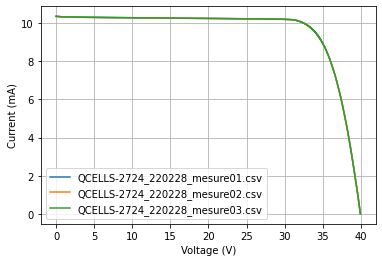

In [4]:
# Standard Library import 
import os
import matplotlib.pyplot as plt
from pathlib import Path

# Local imports 
import PVcharacterization_Utils as pv

# setting the data folder 
path_root = Path.home() 
data_folder = pv.assess_path_folders(path_root)
print('data_folder =', data_folder)

#listing the files 
file_list = os.listdir(data_folder)
selected_file_list = pv.select_items(file_list,'selection of files',mode = 'multiple')
print('selected_file_list =', selected_file_list)

#reading  flashtest files and plotting iv curves 
for file in selected_file_list: 
    #reading flash test files
    filepath = data_folder / Path(file)
    data = pv.read_flashtest_file(filepath, parse_all=True)
    
    #plotting the IV curves
    iv_curve = data.IV0 
    plt.plot(iv_curve["Voltage"],   #[::70]
                iv_curve["Current"],   #[::70]
                label=f'{file}',
                alpha=1)
plt.xlabel("Voltage (V)")
plt.ylabel("Current (mA)")
plt.legend()
plt.grid()
plt.show()
    

In [2]:
def parse_filename_test_control(file,warning=False):

    '''
    Let the string "file" structured as follow:
      '~/XXXXXXX_<YYMMDD>_measure<dd>.csv'
    where <> is a placeholder, d a digit, X a capital letter and ~ the relative or absolute path of the file
    
    parse_filename parses "file" in three chunks: , <YYMMDD>, measure<dd> and stores them in
    the nametuple FileInfo. In addition the extention is checked and must be .csv
    
    Args:
       file (str): filename to parse
       warning (bool): print the warning if true (default=False)
    
    Returns:
        data (namedtuple): results of the file parsing (see summary)
        
    Examples:
    let file = 'C:/Users/franc/PVcharacterization_files/QCELLS-2724_220307_mesure05.csv'
    we obtain:
        FileInfo.module_name = QCELLS-2724
        FileInfo.date = 220307
        FileInfo.mesure = "mesure05"
        FileInfo.status= True
     
    
    '''
    
    # Standard library imports
    import os
    from collections import namedtuple
    from datetime import datetime, timedelta 
    
    
    convert_to_date = lambda s: datetime.strptime(s, "%Y%m%d")
    
    FileNameInfo = namedtuple("FileNameInfo", "exp_id date exp_num module_type file_full_path status")
    
    file_full_path = file
    file = os.path.split(file)[-1]
    status=True
    
    try: # Find irradiance field
        module,date,mesure = file[:-4].split('_')
        date = convert_to_date('20'+date)
    except IndexError:
        module,date,mesure=None,None,None
        status=False
        
               
    if not status and warning:  
        print(f'Warning: the file {file}  is not a flash test format')
        
    FileInfo = FileNameInfo(
        exp_id=module,
        date=date,
        exp_num=mesure,
        module_type=module,
        file_full_path=file_full_path,
        status=status,
    )
        
    return FileInfo

def build_df_meta_test_control(list_files): 
    ''' 
    build_df_meta is the master function used to build the dataframe df_meta.
    df_meta has index= module name and columns = `exp_idx` , GLOBAL['COL_NAMES'], `Isc_corr`, `Fill_Factor_corr`, `date`,
    `exp_num`, `module_type`
    where:
        GLOBAL['COL_NAMES'] is defined in PVcharacterization_Utils.config and must contain 'Title', 'Pmax', 'Fill Factor',
    'Voc','Isc', 'Rseries', 'Rshunt', 'Vpm', 'Ipm' these values are extracted from the header of the flash test .cSV files
    
        `Isc_corr`, `Fill_Factor_corr` are the corrected values of Isc and of the fill factor
        
        `date`,`exp_num`, `module_type` are obtained by parsing the filename
    
    Args:
        list_files (list): list of files used to build the df_meta dataframe
    
    Returns:
        A dataframe containing the metadata (columns) of the list of experiences (rows)
    '''
 
    # Standard library imports 
    import os
    
    #3rd party imports
    import numpy as np
    import pandas as pd
    
    #Internal import
    from PVcharacterization_Utils.config import GLOBAL
    from PVcharacterization_Utils.PVcharacterization_flashtest import read_flashtest_file
    from PVcharacterization_Utils.PVcharacterization_flashtest import correct_iv_curve
    from PVcharacterization_Utils.PVcharacterization_flashtest import parse_filename
    
    
    COL_NAMES = GLOBAL['COL_NAMES']
    
    # Building of the dataframe df_meta out of the flashtest files 
    isc_corr = []
    fill_factor_corr = []
    list_files_name = []  # List of files basenames without extension
    list_dict_metadata = []
    list_exp_id = []
    list_date =[]
    list_measure = []
    list_module_type = []
    
    for file in list_files:
        iv_info = read_flashtest_file(file, parse_all=True)
        list_dict_metadata.append(iv_info.meta_data)
      
        
        # Compure the corrected Isc current and Fill Factor out of the I/V curves
        voltage = iv_info.IV0["Voltage"]
        current = iv_info.IV0["Current"]
        corrected_current = correct_iv_curve(voltage,current)
        isc_corr.append(np.round(corrected_current[0],3))
        fill_factor_corr.append(np.round(max(voltage*current)/(corrected_current[0]*max(voltage)),3))
        list_files_name.append(os.path.splitext(os.path.basename(file))[0])
        
        # Add exp_id, irradiance, treatment, module_type from the filename prsing 
        file_info = parse_filename_test_control(file)
        list_exp_id.append(file_info.exp_id)
        list_date.append(file_info.date)
        list_measure.append(file_info.exp_num)
        list_module_type.append(file_info.module_type)
        
        
    df_meta = pd.DataFrame.from_dict(list_dict_metadata)
    df_meta.index = list_files_name    #df_meta['ID']
    df_meta = df_meta.loc[:,COL_NAMES] # keep only the columns which names COL_NAMES 
                                       #  defined in PVcharacterization_GUI.py
    df_meta['Isc_corr'] = isc_corr
    df_meta['Fill Factor_corr'] = fill_factor_corr
    df_meta['date'] = list_date
    df_meta['exp_num'] = list_measure
    df_meta['module_type'] = list_module_type
    df_meta.insert(0, "exp_id", list_exp_id)
    
    return df_meta

Number of detected displays: 2


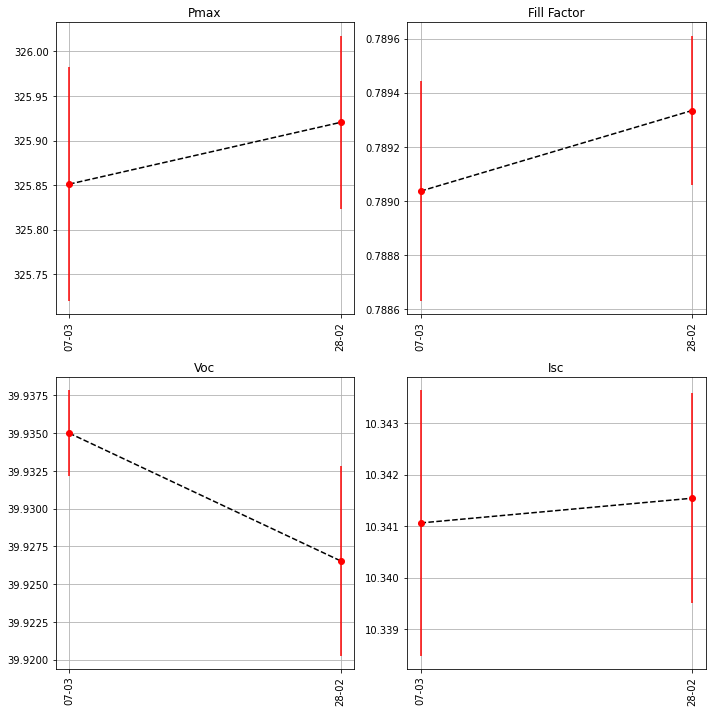

In [3]:

import os
from pathlib import Path

import matplotlib.pyplot as plt

from PVcharacterization_Utils.PVcharacterization_plot import select_params

in_dir = Path(r'C:\Users\franc\PVcharacterization_files\suivi_module_test')
file_list = os.listdir(in_dir)

df_meta = build_df_meta_test_control([in_dir / Path(file) for file in file_list])

list_params = select_params()

df_meta['date'] = df_meta['date'].dt.strftime('%d-%m')
df_meta_mean = df_meta.groupby('date').aggregate('mean')
df_meta_std = df_meta.groupby('date').aggregate('std')


fig, ax = plt.subplots(2, 2,figsize=(10,10))
for idx, param in enumerate(list_params):
    
    ax[idx//2,idx%2].errorbar(df_meta_mean.index,
                              df_meta_mean[param].tolist(),
                              df_meta_std[param],
                              fmt='o',
                              color='r' )
    #ax[idx//2,idx%2].errorbar(x, y, yerr=.1, fmt='', )
    ax[idx//2,idx%2].plot(df_meta_mean.index ,df_meta_mean[param].tolist(),'--k' )
    ax[idx//2,idx%2].set_title(param)
    ax[idx//2,idx%2].tick_params(axis='x',labelrotation=90)
    ax[idx//2,idx%2].grid()
plt.tight_layout()
plt.show()

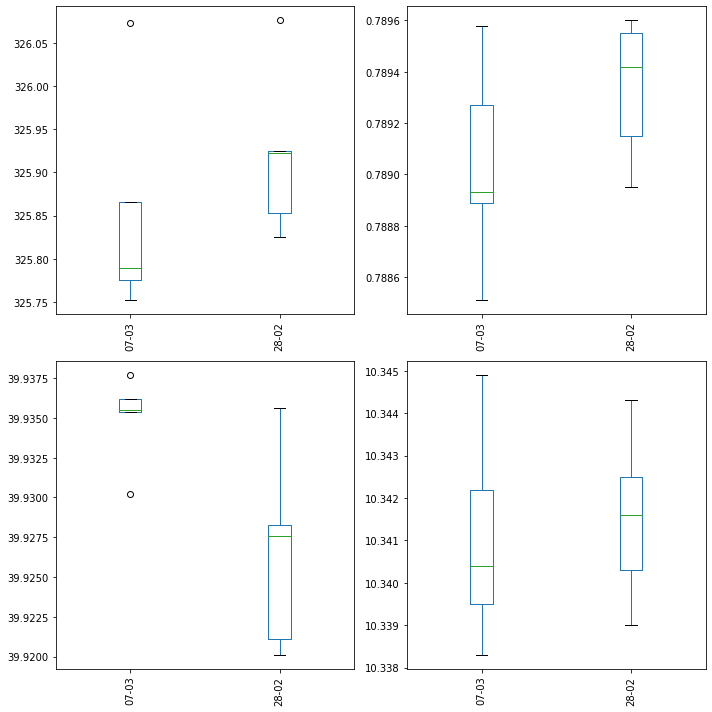

In [4]:
import pandas as pd
fig, ax = plt.subplots(2, 2,figsize=(10,10))

for  idx,param in enumerate(list_params):

    dg = pd.DataFrame.from_dict({date:dg[param].values for date,dg in df_meta.groupby('date')})

    dg.boxplot(ax=ax[idx//2,idx%2]) 
    ax[idx//2,idx%2].tick_params(axis='x',labelrotation=90)
    ax[idx//2,idx%2].grid()
plt.tight_layout()
plt.show()
    

In [15]:
import re
from string import Template

list_inst_raw = [r'cvs vc -&LITEN from 2zsxv@ GRENOBLE',
                 r'cvs vc \LITENe from 2zsxv@ FRance',
                 r'cvs vc *ines litenbaba from 2zsxv@ FRance',
                 r'cvs vc  UNIVERSITY    GRENOBLE  ALPES from 2zsxv@ FRance',]
list_inst = ['LITEN','INES','UNIVERSITY GRENOBLE ALPES']

list_inst_clean = []
for x in list_inst_raw:
    for inst in list_inst:
        inst_split = inst.split()
        template_inst = Template(r'\s+'.join([r'(\b$inst'+str(i)+r'\b)' for i in range(len(inst_split))]))
        dic = {'inst'+str(i):inst for i,inst in enumerate(inst_split)}
        re_inst  = re.compile(template_inst.substitute(dic), re.IGNORECASE)
        if re_inst.findall(x):
            list_inst_clean.append(inst)
list_inst_clean        

(\bLITEN\b)
(\bINES\b)
(\bUNIVERSITY\b)\s+(\bGRENOBLE\b)\s+(\bALPES\b)
(\bLITEN\b)
(\bINES\b)
(\bUNIVERSITY\b)\s+(\bGRENOBLE\b)\s+(\bALPES\b)
(\bLITEN\b)
(\bINES\b)
(\bUNIVERSITY\b)\s+(\bGRENOBLE\b)\s+(\bALPES\b)
(\bLITEN\b)
(\bINES\b)
(\bUNIVERSITY\b)\s+(\bGRENOBLE\b)\s+(\bALPES\b)


['LITEN', 'INES', 'UNIVERSITY GRENOBLE ALPES']